In [10]:
import os

# Set the MPLCONFIGDIR environment variable to a writable directory
os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'

In [11]:
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import os
# Read the CSV file into a DataFrame  freetown_deeplab_confidence_processed.csv
df = pd.read_csv('/teamspace/studios/this_studio/freetown_deeplab_confidence_processed.csv')
df['Deeplab Confidence'] = pd.to_numeric(df['Deeplab Confidence'], errors='coerce')
# Count the number of rows where 'Deeplab Confidence' is greater than 0.85
confidence_gt_085_count = df[df['Deeplab Confidence'] > 0.95]
file_list = confidence_gt_085_count['File'].tolist()



In [12]:
print(file_list[0])

freetown/GMELARBO/2021.10.30.11.36.31_8.449683333333335_-13.211455000000004_610d6400-3f6e-4578-8a3d-7c30f1646e1a_IMG_20211030_102039_5808497641483537263.jpg


In [13]:
print(len(file_list))

326


In [14]:
from dotenv import load_dotenv
import os

env_path = 'Deeplab/credentials.env'
load_dotenv(dotenv_path=env_path)

False

In [15]:
%cd /teamspace/studios/this_studio/Deeplab/
import wget
from inference.infer import *
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_link = 'https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.03.28.12.34.59_-4.531118333333334_38.248731666666664_6973c014-d0e7-4fa8-a80f-9495bfc8af3d_IMG_20210322_094829_8180242403936928723.jpg'
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'
downstreamed_large = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth'
downstreamed_small = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth'
downstreamed_tuned = '/teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth'

/teamspace/studios/this_studio/Deeplab


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [16]:
import boto3 

s3 = boto3.resource()

In [40]:
import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral
from PIL import Image
from torchvision.io import read_image, write_jpeg
import torch
import torchvision.transforms as transforms

def show(image):
  sample = Image.open(image)
  plt.imshow(sample)
  plt.axis("off")
  plt.show()
  plt.close()
    
def apply_dense_crf(img, mask):
    """
    Applies DenseCRF to refine the segmentation mask.
    
    Args:
    - img (numpy array): The original image.
    - mask (numpy array): The initial segmentation mask.
    
    Returns:
    - refined_mask (numpy array): The refined segmentation mask.
    """
    # Convert image to numpy array if it's a tensor
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0)

    # Get height and width of image
    h, w = img.shape[:2]

    # Ensure mask is a 2D array
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif mask.ndim == 3 and mask.shape[0] == 3:  # In case the mask is RGB
        mask = mask[0]

    # Ensure mask has the same height and width as the image
    assert mask.shape == (h, w), f"Mask shape {mask.shape} does not match image shape {(h, w)}"

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(w, h, 2)

    # Create unary potentials
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to range [0, 1]
    unary = np.stack([mask, 1 - mask], axis=0)  # Swapped to correctly represent foreground and background
    unary = unary.reshape((2, -1))  # Shape should be (num_classes, height*width)
    d.setUnaryEnergy(unary)

    # Create pairwise potentials
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=img, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Perform inference
    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

def clean_and_save_mask_with_crf(mask_path, img_path, output_path):
    """
    Read a binary mask and image from files, clean the mask using DenseCRF, and save the cleaned mask.
    
    Args:
    - mask_path (str): Path to the input binary mask file.
    - img_path (str): Path to the original image file.
    - output_path (str): Path to save the cleaned binary mask.
    """
    # Read the binary mask image
    mask = read_image(mask_path).numpy().squeeze()  # Assuming the mask is a single channel image
    if mask.ndim == 3 and mask.shape[0] == 1:  # If there's an extra channel dimension
        mask = mask[0]
    
    # Read the original image
    img = np.array(Image.open(img_path).convert('RGB'))

    # Apply DenseCRF to refine the mask
    refined_mask = apply_dense_crf(img, mask)

    # Save the cleaned binary mask
    cleaned_mask_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
    cleaned_mask_img.save(output_path)

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_overlayed_mask(img_path, mask_path, input_box):
    # Load the original image
    img = Image.open(img_path).convert('RGB')

    # Load the binary mask as a blue image
    binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
    binary_mask_blue = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    binary_mask_blue[:, :, 0] = 0  # Set red channel to 0
    binary_mask_blue[:, :, 1] = 0  # Set green channel to 0

    # Convert binary mask to a NumPy array with True (255) and False (0) values
    binary_array = (binary_mask == 255)

    # Set the size of the plot
    plt.figure(figsize=(10, 10))  # Adjust the width and height as needed

    # Overlay the binary mask on the original image
    plt.imshow(img)
    plt.imshow(binary_mask_blue, alpha=0.7)
    show_box(input_box, plt.gca())
    plt.axis('off')

    # Remove ticks
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Save the figure
    plt.savefig('overlayed_mask.jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

# Example usage

import torchvision.transforms as transforms
from PIL import Image

def fit(input_path, output_path):
    resize = transforms.Resize((512, 512))
    resized_image = resize(Image.open(input_path))
    resized_image.save(output_path) 

from PIL import Image, ExifTags

def flip(filepath, new_path):
  try:
      image=Image.open(filepath)

      for orientation in ExifTags.TAGS.keys():
          if ExifTags.TAGS[orientation]=='Orientation':

              break
      #print(ExifTags.TAGS.keys())
      exif = image._getexif()
      #print(exif[orientation])

      if exif[orientation] == 3:
          print('Fixing Image Flipping. Exif tag was 3')
          image=image.rotate(180, expand=True)
      elif exif[orientation] == 6:
          print('Fixing Image Flipping. Exif tag was 6')
          image=image.rotate(270, expand=True)
      elif exif[orientation] == 8:
          print('Fixing Image Flipping. Exif tag was 8')
          image=image.rotate(90, expand=True)


      image.save(new_path)
      image.close()
  except:
      # cases: image don't have getexif
      print('no ExifTags found.')
      pass

# Example usage
'''
mask_path = 'Deeplab/check.jpg'
img_path = 'test.jpg'
output_path = 'cleaned_mask_with_crf.jpg'
clean_and_save_mask_with_crf(mask_path, img_path, output_path)
'''
from torchvision.io import read_image

def pil_to_grayscale_tensor(image):
    grayscale_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
    return grayscale_transform(image)

# Read the image using PIL


from torchvision.ops import masks_to_boxes
'''
# Now, mask tensor should have dimensions [1, 512, 512]
boxes = masks_to_boxes(pil_to_grayscale_tensor(Image.open('/teamspace/studios/this_studio/cleaned_mask_with_crf.jpg')))
#boxes = boxes.numpy()
print(boxes[0].tolist())
    
'''


"\n# Now, mask tensor should have dimensions [1, 512, 512]\nboxes = masks_to_boxes(pil_to_grayscale_tensor(Image.open('/teamspace/studios/this_studio/cleaned_mask_with_crf.jpg')))\n#boxes = boxes.numpy()\nprint(boxes[0].tolist())\n    \n"

In [6]:
import os 
import matplotlib.image as mpimg
current_directory = os.getcwd()
os.chdir('/teamspace/studios/this_studio/sam-hq')
from segment_anything import sam_model_registry, SamPredictor


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

os.chdir(current_directory)

def sam_predict(image_path, input_box):
    image = mpimg.imread(image_path)
    image = image.astype(np.uint8)
    
    predictor.set_image(image)
    
    #input_box = np.array(boxes.tolist()[0])
    
    masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
    )
    
    print("SAM score for this mask is: " + str(scores[0]))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()


/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is no

<All keys matched successfully>


In [11]:
import os
current_directory = os.getcwd()

# Change to the desired directory
os.chdir('/teamspace/studios/this_studio/sam-hq')

# Import the required modules or define functions

# Restore the original working directory
os.chdir(current_directory)

In [27]:
print(os.getcwd())

/teamspace/studios/this_studio


In [49]:
def get_prob(checkpoint, to_download, use_url=True, my_bucket = s3.Bucket('treetracker-training-images'), save_binary_mask=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()
    img_path = '/teamspace/studios/this_studio/test.jpg'
    if use_url:
        
        urllib.request.urlretrieve(to_download, img_path)
        #!wget -q $to_download -O $img_path
    else:
        my_bucket.download_file(to_download, '/teamspace/studios/this_studio/test.jpg')
        #img_path = to_download  # Assuming `to_download` contains the local path in this case
    flip(img_path,img_path)
    
    #img = flip(Image.open(img_path)).convert('RGB')
    img = Image.open(img_path)
    show(img_path)
    img_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        output = model(img_tensor)
        output = torch.squeeze(output, dim=1)
        prob = torch.sigmoid(output).detach()
        pred = (prob > 0.5).long().cpu().numpy()[0]

    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_np = img_tensor[0].detach().cpu().numpy()
    img_np = (denorm(img_np) * 255).transpose(1, 2, 0).astype(np.uint8)

    prob_np = prob[0].cpu().numpy()
    count = np.sum(prob_np > 0.5)
    confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0
    
    if count == 0:
        print('Nothing detected')
    else:
        print('Confidence is ' + str(confidence))
    if save_binary_mask:
        pred_rgb = np.array(decode_target(pred)).astype(np.uint8)
        pred_image = Image.fromarray(pred_rgb).convert('RGB')
        pred_image.save('check.jpg')
    return prob_np

Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth
no ExifTags found.


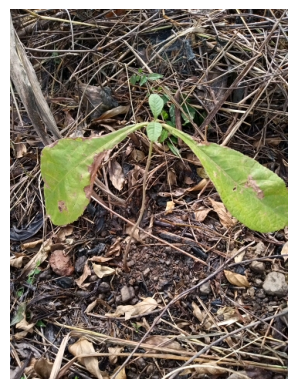

Confidence is 0.9559707179050316
[[0.01701348 0.01701348 0.01775198 ... 0.01076192 0.01003998 0.01003998]
 [0.01701348 0.01701348 0.01775198 ... 0.01076192 0.01003998 0.01003998]
 [0.017209   0.017209   0.01804978 ... 0.01084187 0.01018271 0.01018271]
 ...
 [0.02042391 0.02042391 0.02018101 ... 0.02612611 0.02580439 0.02580439]
 [0.02053037 0.02053037 0.02037275 ... 0.02563261 0.02522759 0.02522759]
 [0.02053037 0.02053037 0.02037275 ... 0.02563261 0.02522759 0.02522759]]


In [50]:
a = get_prob(inhouse_default, file_list[0], use_url= False, my_bucket = s3.Bucket('treetracker-training-images'))
print(a)

Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth
No ExifTags found: 'str' object has no attribute '_getexif'
Confidence is 0.9470074759601522


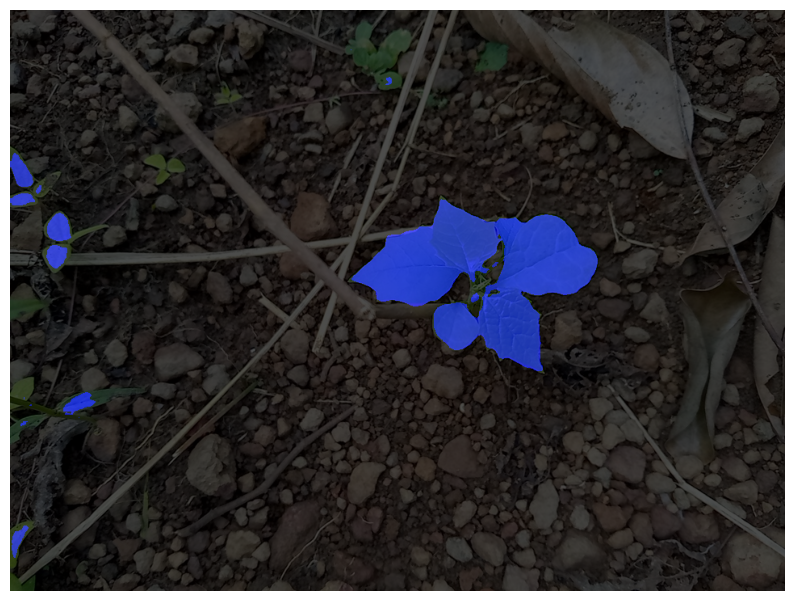

Overlayed Mask saved to /teamspace/studios/this_studio/Deeplab/test_overlayed.jpg
Binary Mask saved to /teamspace/studios/this_studio/Deeplab/test_binary.jpg


In [32]:
get_overlayed_mask(inhouse_default, file_list[3], use_url= False, my_bucket = s3.Bucket('treetracker-training-images'))

In [51]:
# Checking
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian

def crf_with_prob(img, mask, prob):
    """
    Applies DenseCRF to refine the segmentation mask.
    
    Args:
    - img (numpy array): The original image.
    - mask (numpy array): The initial segmentation mask.
    - prob (numpy array): The probability array indicating likelihood of pixels being in the foreground.
    
    Returns:
    - refined_mask (numpy array): The refined segmentation mask.
    """
    # Convert image to numpy array if it's a tensor
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0)

    # Get height and width of image
    h, w = img.shape[:2]

    # Ensure mask is a 2D array
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif mask.ndim == 3 and mask.shape[0] == 3:  # In case the mask is RGB
        mask = mask[0]

    # Ensure mask has the same height and width as the image
    assert mask.shape == (h, w), f"Mask shape {mask.shape} does not match image shape {(h, w)}"

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(w, h, 2)

    # Create unary potentials
# Create unary potentials
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to range [0, 1]
    #unary_bg = 1 - prob  # Background unary potential
    #unary_fg = prob  # Foreground unary potential
    unary = np.stack([prob, 1 - prob], axis=0) 
    unary = unary.reshape((2, -1))
    #unary = np.stack([unary_bg, unary_fg], axis=-1)  # Stack to create unary potentials
    d.setUnaryEnergy(unary)


    # Create pairwise potentials
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=img, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Perform inference
    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

def clean_with_prob(mask_path, img_path, output_path, prob):
    """
    Read a binary mask and image from files, clean the mask using DenseCRF, and save the cleaned mask.
    
    Args:
    - mask_path (str): Path to the input binary mask file.
    - img_path (str): Path to the original image file.
    - output_path (str): Path to save the cleaned binary mask.
    """
    # Read the binary mask image
    mask = read_image(mask_path).numpy().squeeze()  # Assuming the mask is a single channel image
    if mask.ndim == 3 and mask.shape[0] == 1:  # If there's an extra channel dimension
        mask = mask[0]
    
    # Read the original image
    img = np.array(Image.open(img_path).convert('RGB'))

    # Apply DenseCRF to refine the mask
    refined_mask = crf_with_prob(img, mask, prob)

    # Save the cleaned binary mask
    cleaned_mask_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
    cleaned_mask_img.save(output_path)


In [37]:
# THIS WORKS!
def crf_with_prob(img, mask, prob):
    """
    Applies DenseCRF to refine the segmentation mask.
    
    Args:
    - img (numpy array): The original image.
    - mask (numpy array): The initial segmentation mask.
    - prob (numpy array): The probability array indicating likelihood of pixels being in the foreground.
    
    Returns:
    - refined_mask (numpy array): The refined segmentation mask.
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0)

    # Get height and width of image
    h, w = img.shape[:2]

    # Ensure mask is a 2D array
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif mask.ndim == 3 and mask.shape[0] == 3:  # In case the mask is RGB
        mask = mask[0]
    # Ensure mask has the same height and width as the image
    assert mask.shape[:2] == img.shape[:2], f"Mask shape {mask.shape} does not match image shape {img.shape}"

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], 2)  # Note: Width and height swapped for DenseCRF

    # Create unary potentials
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to range [0, 1]
    unary_bg = mask * (1 - prob)  # Background unary potential
    unary_fg = (1 - mask) * prob  # Foreground unary potential
    unary = np.stack([unary_bg, unary_fg], axis=-1)  # Stack to create unary potentials
    unary = unary.reshape((2, -1))
    unary = unary + 1e-8
    d.setUnaryEnergy(-np.log(unary))

    # Create pairwise potentials
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=img, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Perform inference
    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))

    return refined_mask



def clean_with_prob(mask_path, img_path, output_path, prob):
    """
    Read a binary mask and image from files, clean the mask using DenseCRF, and save the cleaned mask.
    
    Args:
    - mask_path (str): Path to the input binary mask file.
    - img_path (str): Path to the original image file.
    - output_path (str): Path to save the cleaned binary mask.
    """
    # Read the binary mask image
    mask = read_image(mask_path).numpy().squeeze()  # Assuming the mask is a single channel image
    if mask.ndim == 3 and mask.shape[0] == 1:  # If there's an extra channel dimension
        mask = mask[0]
    
    # Read the original image
    img = np.array(Image.open(img_path).convert('RGB'))

    # Apply DenseCRF to refine the mask
    refined_mask = crf_with_prob(img, mask, prob)

    # Save the cleaned binary mask
    cleaned_mask_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
    cleaned_mask_img.save(output_path)


In [18]:
def fit(input_path, output_path):
    resize = transforms.Resize((512, 512))
    resized_image = resize(Image.open(input_path))
    resized_image.save(output_path) 

In [23]:
img_path = '/teamspace/studios/this_studio/Deeplab/check.jpg'
image = Image.open(img_path)
print(image.size)

(512, 512)


In [42]:
def show_overlayed_mask(img_path, mask_path):
    # Load the original image
    img = Image.open(img_path).convert('RGB')

    # Load the binary mask as a blue image
    binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
    binary_mask_blue = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    binary_mask_blue[:, :, 0] = 0  # Set red channel to 0
    binary_mask_blue[:, :, 1] = 0  # Set green channel to 0

    # Convert binary mask to a NumPy array with True (255) and False (0) values
    binary_array = (binary_mask == 255)

    # Set the size of the plot
    plt.figure(figsize=(10, 10))  # Adjust the width and height as needed

    # Overlay the binary mask on the original image
    plt.imshow(img)
    plt.imshow(binary_mask_blue, alpha=0.7)
    #show_box(input_box, plt.gca())
    plt.axis('off')

    # Remove ticks
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Save the figure
    plt.savefig('overlayed_mask.jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

/teamspace/studios/this_studio/Deeplab/check.jpg


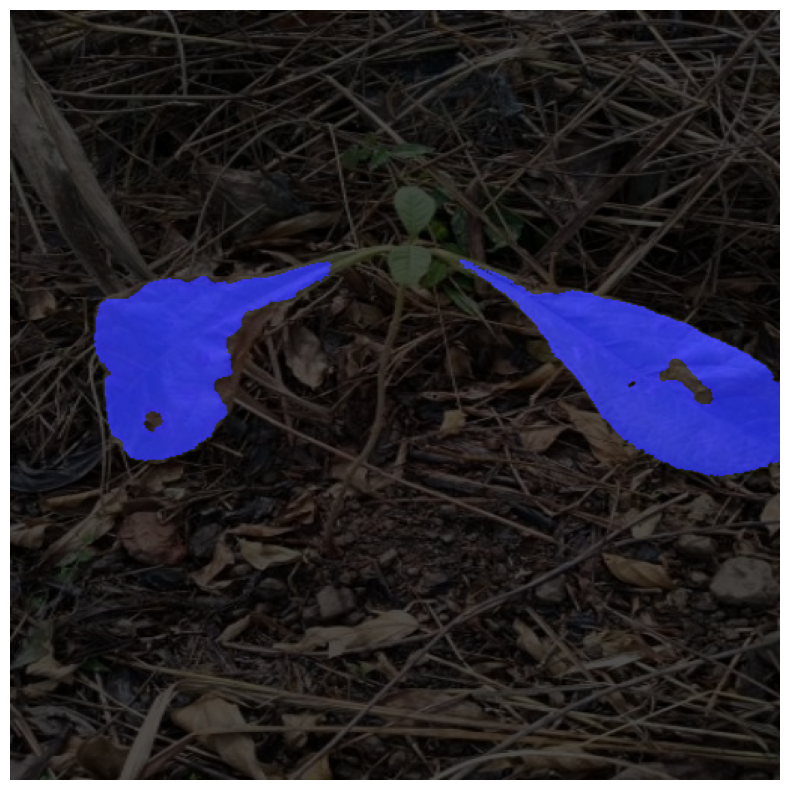

In [52]:
import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral
from PIL import Image
from torchvision.io import read_image, write_jpeg
import torch
import torchvision.transforms as transforms
    
img_path = '/teamspace/studios/this_studio/test.jpg'
# Deeplab/check.jpg
mask_path = '/teamspace/studios/this_studio/Deeplab/check.jpg'
output_path = '/teamspace/studios/this_studio/cleaned_mask_with_crf_prob.jpg'  

fit(img_path,img_path)
fit(mask_path,mask_path)

'''
flip(img_path,img_path)
flip(mask_path,mask_path)
'''
print(mask_path)

clean_with_prob(mask_path, img_path, output_path, a)
#show(img_path)
show_overlayed_mask(img_path, output_path)


/teamspace/studios/this_studio/Deeplab/check.jpg


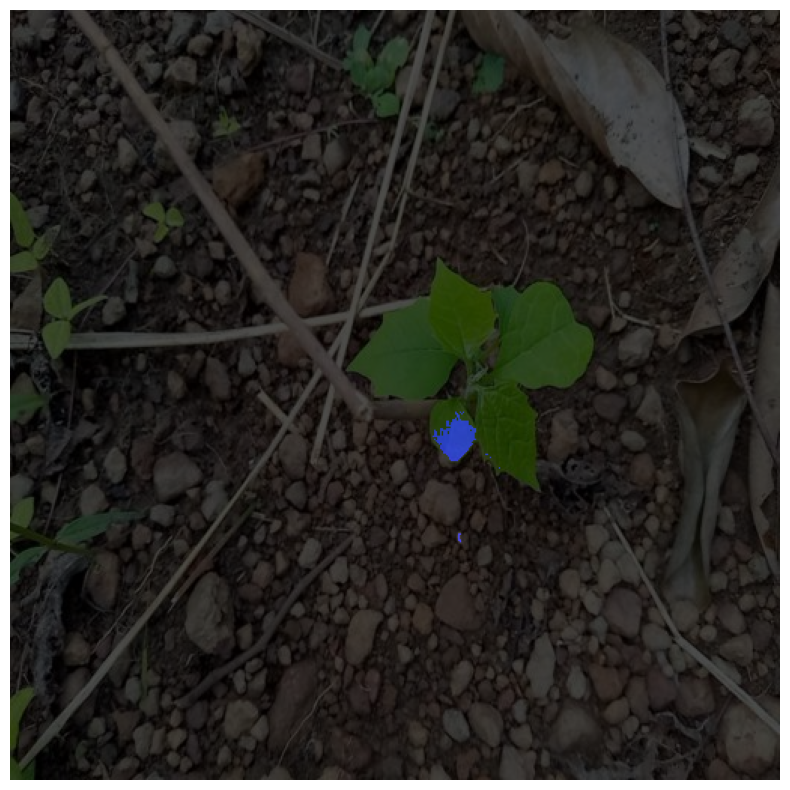

In [43]:

    
img_path = '/teamspace/studios/this_studio/test.jpg'
# Deeplab/check.jpg
mask_path = '/teamspace/studios/this_studio/Deeplab/check.jpg'
output_path = '/teamspace/studios/this_studio/cleaned_mask_with_crf.jpg'  

fit(img_path,img_path)
fit(mask_path,mask_path)
'''
flip(img_path,img_path)
flip(mask_path,mask_path)
'''
print(mask_path)

clean_and_save_mask_with_crf(mask_path, img_path, output_path)
#show(img_path)
show_overlayed_mask(img_path, output_path)





SAM score for this mask is: 0.9792791


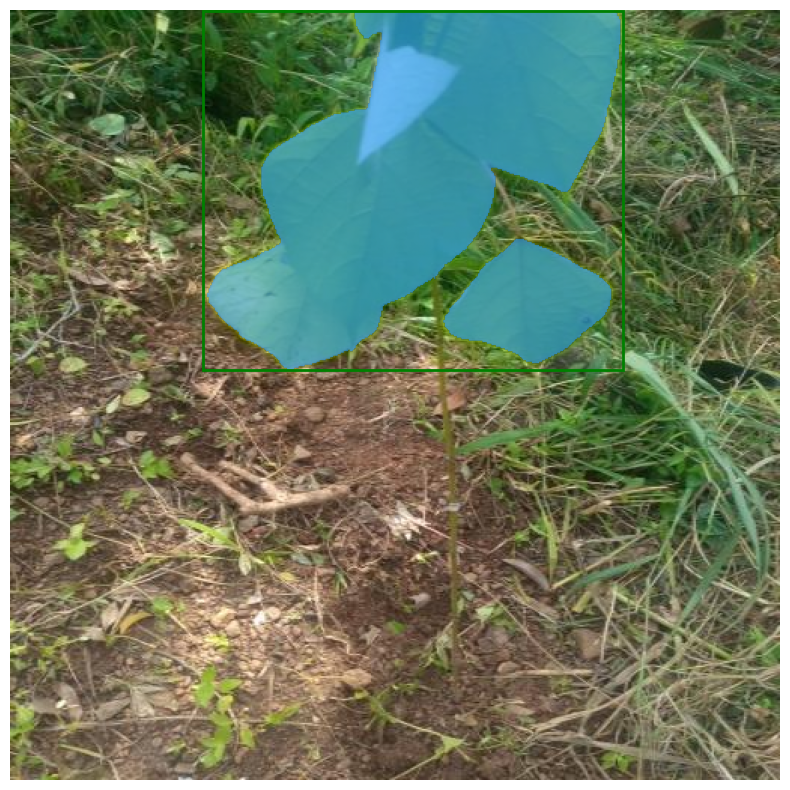

In [15]:
boxes = masks_to_boxes(pil_to_grayscale_tensor(Image.open(output_path)))
sam_predict(img_path, np.array(boxes.tolist()[0]))
